# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Mon Jul 18 12:55:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P0    57W / 240W |   1699MiB /  8192MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

In [3]:
# Import series of helper functions for out notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data
Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-07-18 12:59:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.16.176, 142.251.36.240, 142.251.36.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.16.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  5.85MB/s    in 4m 34s  

2022-07-18 13:04:28 (5.66 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [9]:
train_dir = "data/101_food_classes_10_percent/train/"
test_dir = "data/101_food_classes_10_percent/test/"

In [10]:
# How many images/classes are there ?
walk_through_dir("data/101_food_classes_10_percent/")

There are 2 directories and 0 images in 'data/101_food_classes_10_percent/'.
There are 101 directories and 0 images in 'data/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in 'data/101_food_classes_10_percent/test/hot_and_sour_soup'.

In [12]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.


2022-07-18 13:13:04.670106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 13:13:04.715993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 13:13:04.716228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-18 13:13:04.716911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [14]:
# Create checkpoint callback
checkpoint_path = "101_calsses_10_percent_weights/101_calsses_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor="val_accuracy",
                                                        sev_best_only=True)

In [15]:
# Create a data augmentation layer to incorportate it  right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
#    preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [25]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs, training=True) # augment images (only happens during traing phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay fozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
# Get a summary of model we've created
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [27]:
# Compile
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5


2022-07-18 13:46:05.333441: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


237/237 [==============================] - 59s 227ms/step - loss: 3.3579 - accuracy: 0.2767 - val_loss: 2.6427 - val_accuracy: 0.4108
Epoch 2/5
237/237 [==============================] - 44s 185ms/step - loss: 2.1977 - accuracy: 0.4950 - val_loss: 2.2552 - val_accuracy: 0.4574
Epoch 3/5
237/237 [==============================] - 42s 178ms/step - loss: 1.8170 - accuracy: 0.5648 - val_loss: 2.1143 - val_accuracy: 0.4785
Epoch 4/5
237/237 [==============================] - 41s 174ms/step - loss: 1.6076 - accuracy: 0.6124 - val_loss: 2.0706 - val_accuracy: 0.4796
Epoch 5/5
237/237 [==============================] - 39s 164ms/step - loss: 1.4476 - accuracy: 0.6432 - val_loss: 2.0010 - val_accuracy: 0.4902


In [28]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 84s 106ms/step - loss: 1.7751 - accuracy: 0.5450


[1.7751089334487915, 0.5450296998023987]

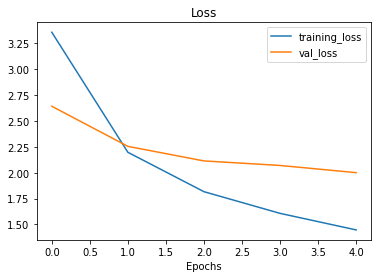

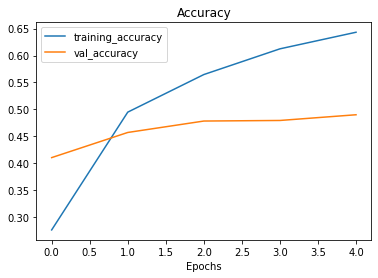

In [29]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning

In [30]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [31]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowerd by 10x
             metrics=["accuracy"])

In [32]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [33]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [34]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 45s 171ms/step - loss: 1.2186 - accuracy: 0.6808 - val_loss: 1.9866 - val_accuracy: 0.4849
Epoch 6/10
237/237 [==============================] - 40s 167ms/step - loss: 1.1037 - accuracy: 0.7046 - val_loss: 1.9723 - val_accuracy: 0.5058
Epoch 7/10
237/237 [==============================] - 37s 158ms/step - loss: 1.0260 - accuracy: 0.7270 - val_loss: 1.9854 - val_accuracy: 0.4921
Epoch 8/10
237/237 [==============================] - 38s 161ms/step - loss: 0.9445 - accuracy: 0.7486 - val_loss: 1.9508 - val_accuracy: 0.5013
Epoch 9/10
237/237 [==============================] - 40s 170ms/step - loss: 0.8774 - accuracy: 0.7650 - val_loss: 1.9082 - val_accuracy: 0.5180
Epoch 10/10
237/237 [==============================] - 41s 171ms/step - loss: 0.8273 - accuracy: 0.7768 - val_loss: 1.9252 - val_accuracy: 0.5079


In [36]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 90s 114ms/step - loss: 1.6529 - accuracy: 0.5732


[1.6528559923171997, 0.5731881260871887]

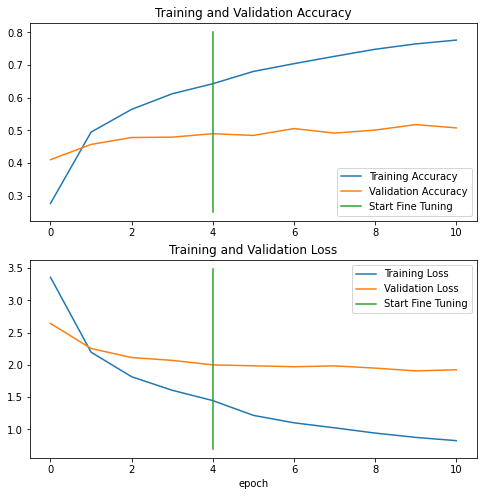

In [37]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [40]:
# Save our fine-tuning model
model.save("models/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: models/101_food_classes_10_percent_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: models/101_food_classes_10_percent_saved_big_dog_model/assets


> 🔑 **Note:** Loading the model with the following cell will output a large amount of warnings, there is a thread tracking this issue on GitHub: https://github.com/tensorflow/tensorflow/issues/40166, however, it seems according to the TensorFlow documentation, loading warnings can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage

In [43]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("models/101_food_classes_10_percent_saved_big_dog_model/")

In [44]:
# Evaluate loaded model and compare performance to pre-sved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 95s 118ms/step - loss: 1.6493 - accuracy: 0.5744


[1.6492983102798462, 0.5744158625602722]

In [46]:
# The results from our loaded_model (above) should be very similar to the resutls below
all_classes_10_percent_fine_tune_results

[1.6528559923171997, 0.5731881260871887]

## Evaluating the performence of the big dog model accross all differnt classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [47]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-07-18 14:46:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.36.208, 142.251.36.176, 142.251.36.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.36.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  5.13MB/s    in 8.2s    

2022-07-18 14:46:19 (5.45 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [49]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [50]:
# Load in saved model
model = tf.keras.models.load_model("models/06_101_food_class_10_percent_saved_big_dog_model/")

In [52]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 59s 74ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [53]:
# Make predictions with out model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 51s 64ms/step


In [54]:
len(test_data)

790

In [56]:
790 * 32 

25280

In [58]:
# How many predictions are there?
len(pred_probs)

25250

In [59]:
# What's the shape of our predicitons?
pred_probs.shape

(25250, 101)

In [60]:
# Let's see what the first 10 predictions look like
pred_probs[:10]

array([[5.95421866e-02, 3.57422277e-06, 4.13771421e-02, ...,
        1.41387779e-09, 8.35307728e-05, 3.08977254e-03],
       [9.64016795e-01, 1.37532463e-09, 8.47804127e-04, ...,
        5.42869966e-05, 7.83623600e-12, 9.84654580e-10],
       [9.59258795e-01, 3.25338660e-05, 1.48669782e-03, ...,
        7.18913498e-07, 5.43977364e-07, 4.02760452e-05],
       ...,
       [4.73133832e-01, 1.29311559e-07, 1.48055388e-03, ...,
        5.97502221e-04, 6.69689471e-05, 2.34693143e-05],
       [4.45716977e-02, 4.72652687e-07, 1.22584455e-01, ...,
        6.34982780e-06, 7.53189579e-06, 3.67788086e-03],
       [7.24389374e-01, 1.92498018e-09, 5.23110248e-05, ...,
        1.22913928e-03, 1.57927693e-09, 9.63956263e-05]], dtype=float32)

In [63]:
# What does the first predcition probability array look like?
pred_probs[0], len(pred_probs[0]), sum(pred_probs[0])

(array([5.9542187e-02, 3.5742228e-06, 4.1377142e-02, 1.0660588e-09,
        8.1614528e-09, 8.6639913e-09, 8.0927452e-07, 8.5652999e-07,
        1.9859246e-05, 8.0977776e-07, 3.1727840e-09, 9.8673854e-07,
        2.8532385e-04, 7.8049284e-10, 7.4230670e-04, 3.8916351e-05,
        6.4740566e-06, 2.4977476e-06, 3.7891357e-05, 2.0678389e-07,
        1.5538484e-05, 8.1507585e-07, 2.6230848e-06, 2.0010746e-07,
        8.3828110e-07, 5.4215993e-06, 3.7391076e-06, 1.3150572e-08,
        2.7761622e-03, 2.8052003e-05, 6.8562361e-10, 2.5574886e-05,
        1.6689059e-04, 7.6407525e-10, 4.0453119e-04, 1.3150725e-08,
        1.7957415e-06, 1.4448275e-06, 2.3062905e-02, 8.2467585e-07,
        8.5365787e-07, 1.7138715e-06, 7.0525784e-06, 1.8402188e-08,
        2.8553407e-07, 7.9484162e-06, 2.0681598e-06, 1.8525245e-07,
        3.3619809e-08, 3.1522740e-04, 1.0410975e-05, 8.5448545e-07,
        8.4741801e-01, 1.0555477e-05, 4.4095097e-07, 3.7404257e-05,
        3.5306304e-05, 3.2489203e-05, 6.7315341e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [65]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542187e-02 3.5742228e-06 4.1377142e-02 1.0660588e-09 8.1614528e-09
 8.6639913e-09 8.0927452e-07 8.5652999e-07 1.9859246e-05 8.0977776e-07
 3.1727840e-09 9.8673854e-07 2.8532385e-04 7.8049284e-10 7.4230670e-04
 3.8916351e-05 6.4740566e-06 2.4977476e-06 3.7891357e-05 2.0678389e-07
 1.5538484e-05 8.1507585e-07 2.6230848e-06 2.0010746e-07 8.3828110e-07
 5.4215993e-06 3.7391076e-06 1.3150572e-08 2.7761622e-03 2.8052003e-05
 6.8562361e-10 2.5574886e-05 1.6689059e-04 7.6407525e-10 4.0453119e-04
 1.3150725e-08 1.7957415e-06 1.4448275e-06 2.3062905e-02 8.2467585e-07
 8.5365787e-07 1.7138715e-06 7.0525784e-06 1.8402188e-08 2.8553407e-07
 7.9484162e-06 2.0681598e-06 1.8525245e-07 3.3619809e-08 3.1522740e-04
 1.0410975e-05 8.5448545e-07 8.4741801e-01 1.0555477e-05 4.4095097e-07
 3.7404257e-05 3.5306304e-05 3.2489203e-05 6.7315341e-05 1.2852657e-08
 2.6219840e-10 1.0318141e-05 8.5743806e-05 1.

In [70]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [71]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [73]:
# To get our test labels we need to unravel our test_data BAtchDataset
y_labels = []
for images,labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, ... 0, 0], we want the index value where the "1" occurrs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [74]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array (pred_classes) is in the same order as our test labels array (y_labels) is to find the accuracy score.

In [76]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [78]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                 y_pred=pre_classes)
sklearn_accuracy

0.6077623762376237

In [80]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [81]:
from helper_functions import make_confusion_matrix

In [83]:
# Get a list of class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [88]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

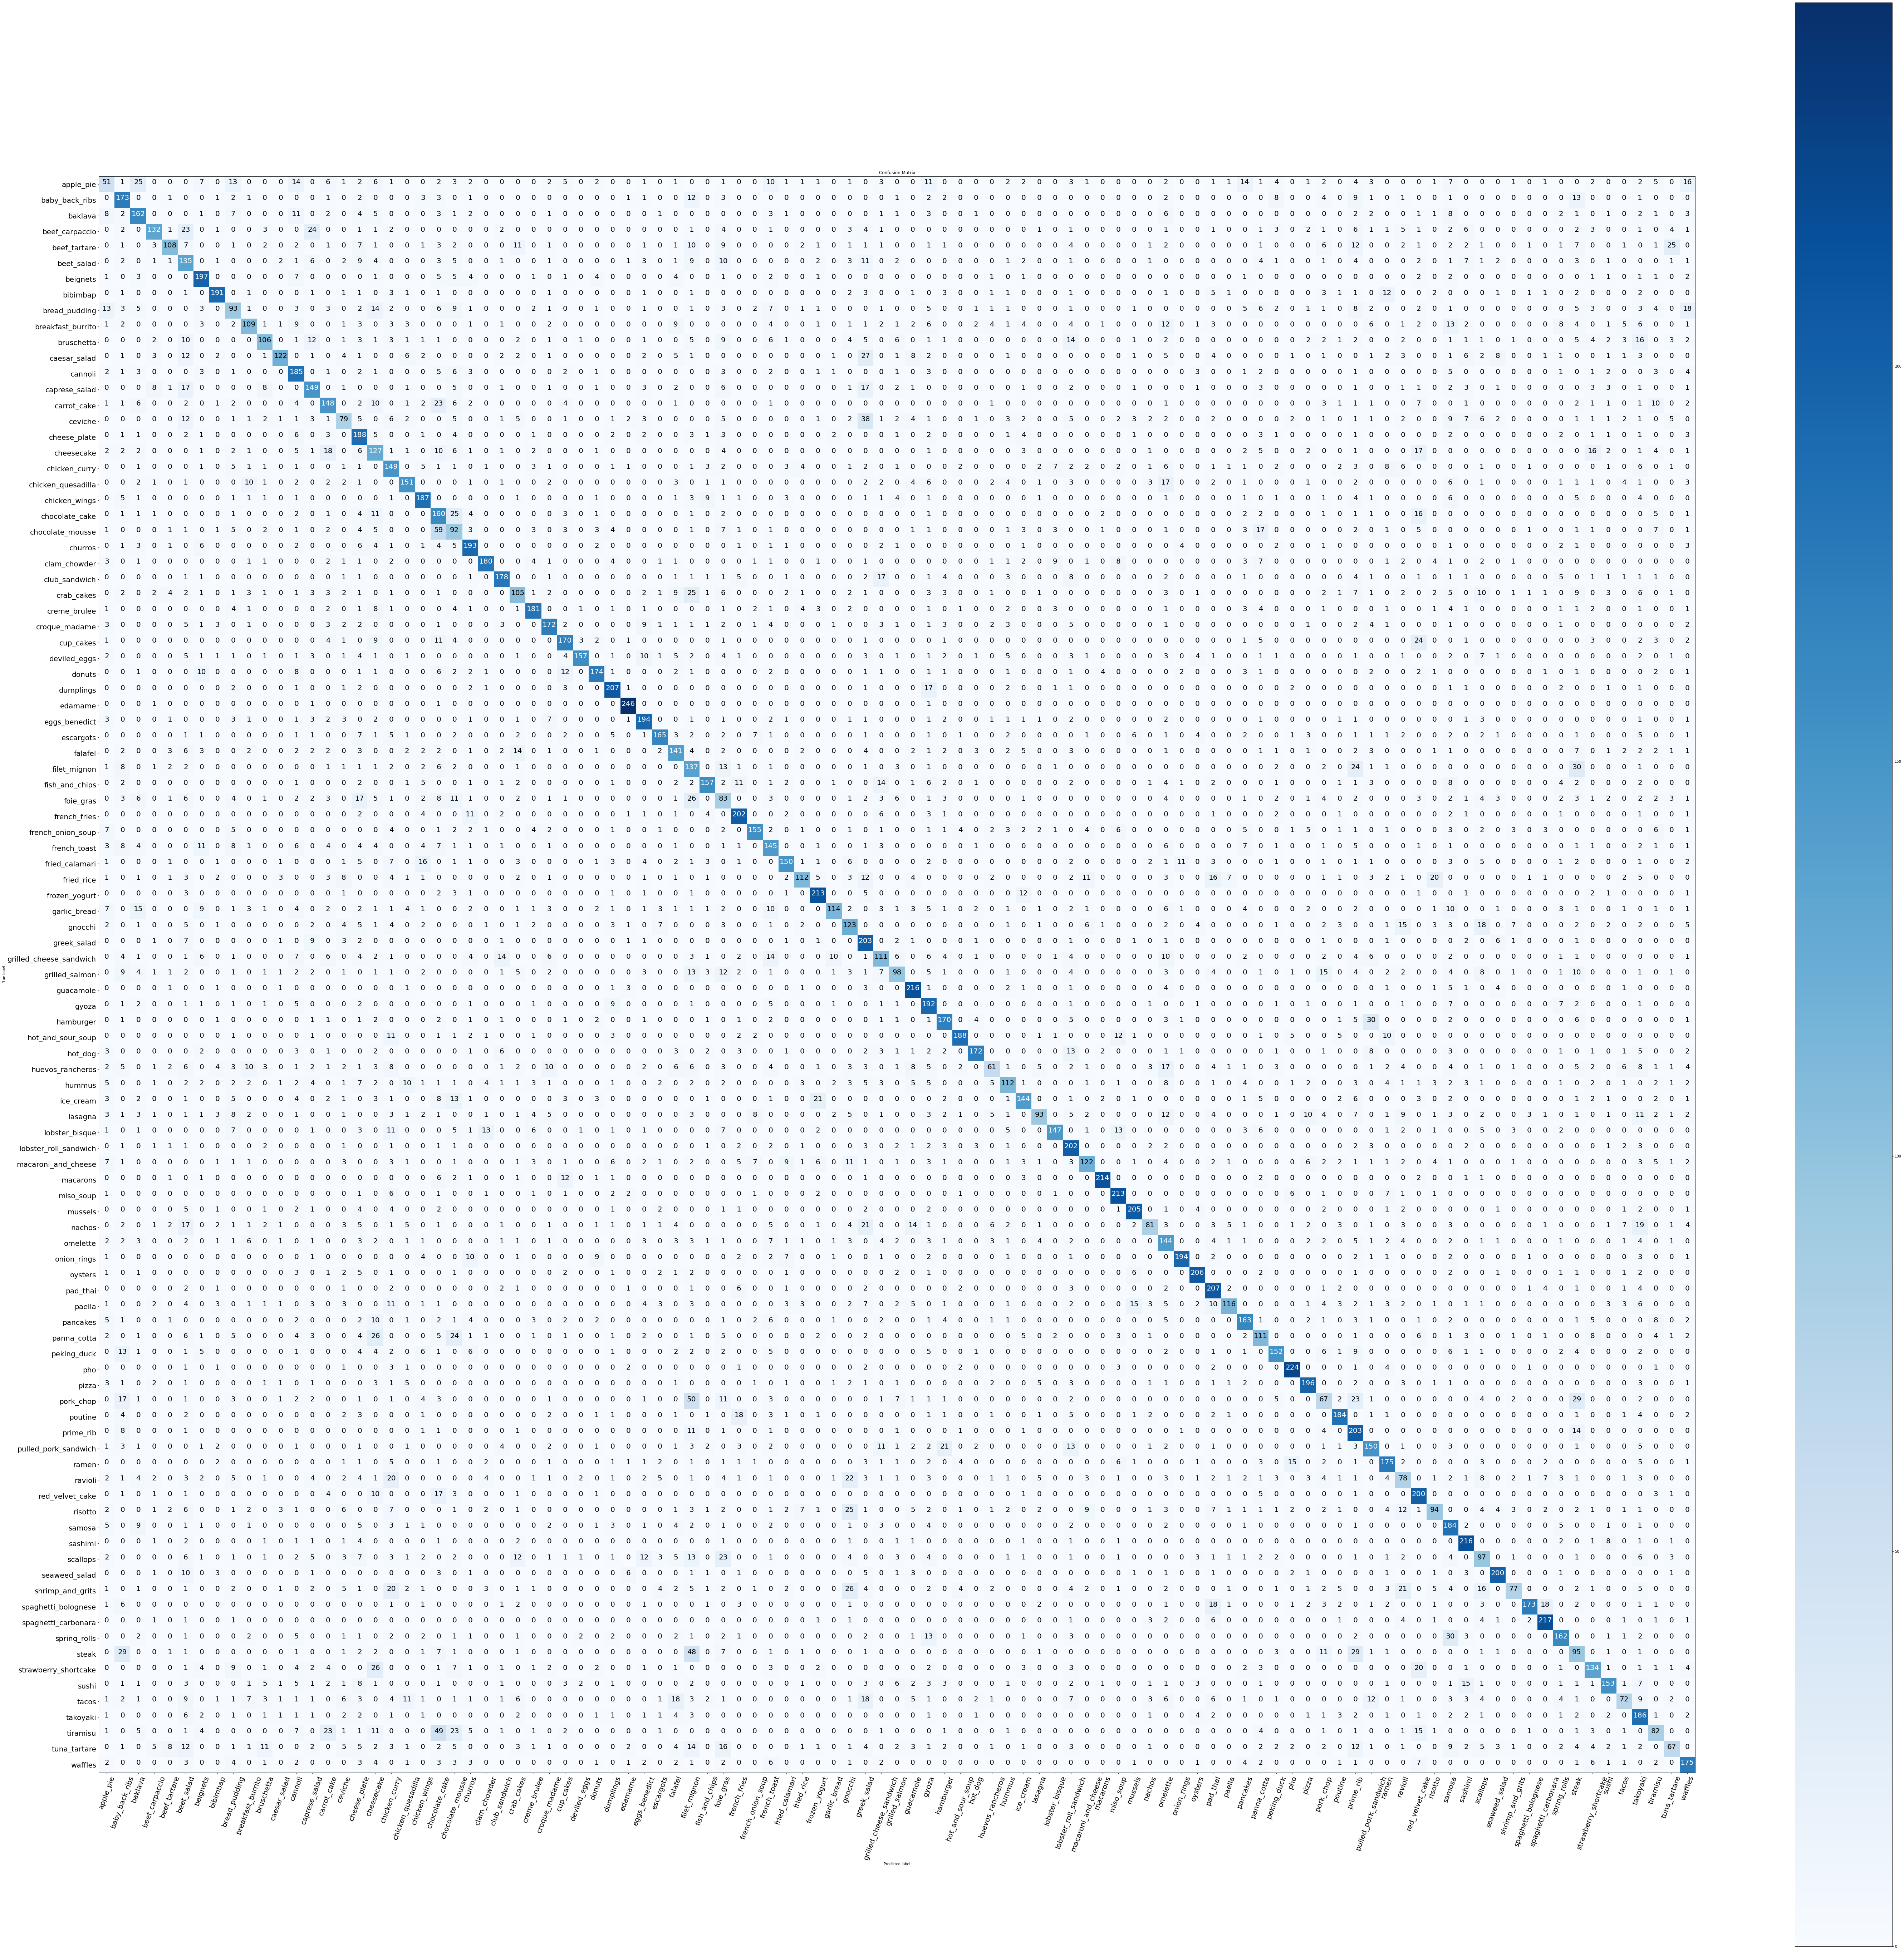

In [90]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     figsize=(100,100),
                     text_size=20,
                     savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out.

In [91]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get a better understanding?

In [92]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pre_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

# Let's plot all of our F1-scores

In [95]:
class_names[98]

'tiramisu'

In [96]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [97]:
# Create a empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [98]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [102]:
f1_scores[:10]

(            class_names  f1-score
 33              edamame  0.937143
 63             macarons  0.895397
 75                  pho  0.866538
 91  spaghetti_carbonara  0.847656
 69              oysters  0.834008
 68          onion_rings  0.832618
 65              mussels  0.820000
 88        seaweed_salad  0.813008
 64            miso_soup  0.812977
 45        frozen_yogurt  0.811429,
             class_names  f1-score
 54    hot_and_sour_soup  0.810345
 7              bibimbap  0.790890
 90  spaghetti_bolognese  0.788155
 32            dumplings  0.785579
 76                pizza  0.780876
 ..                  ...       ...
 56     huevos_rancheros  0.339833
 22     chocolate_mousse  0.329159
 77            pork_chop  0.308756
 39            foie_gras  0.297491
 0             apple_pie  0.240566
 
 [91 rows x 2 columns])

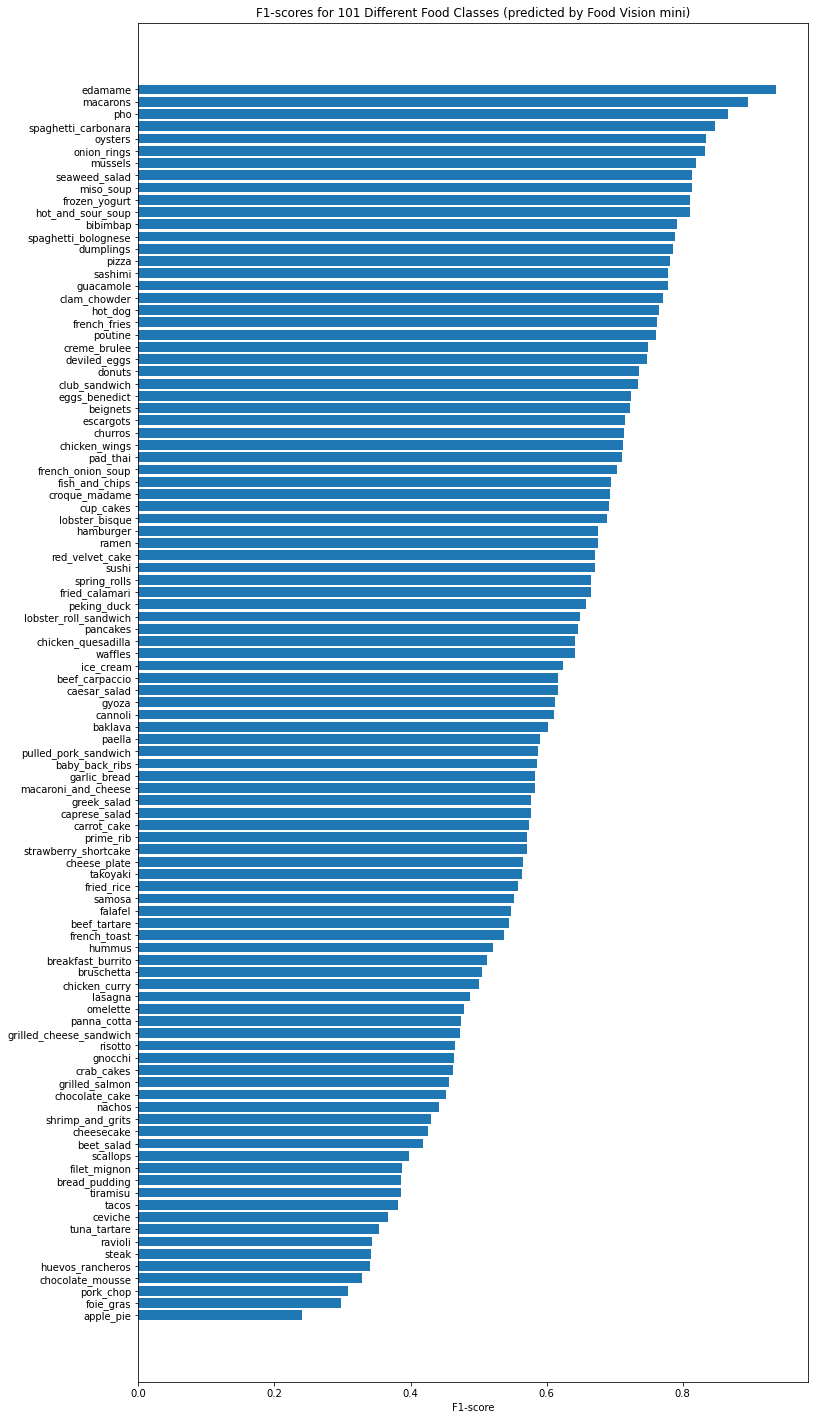

In [108]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot

# Challenge: add values to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)

## Visualizing predictions on test images

Now, this is the real test, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [117]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.

Specifically, we'll write some code to:

1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label

In [118]:
train_data_all_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


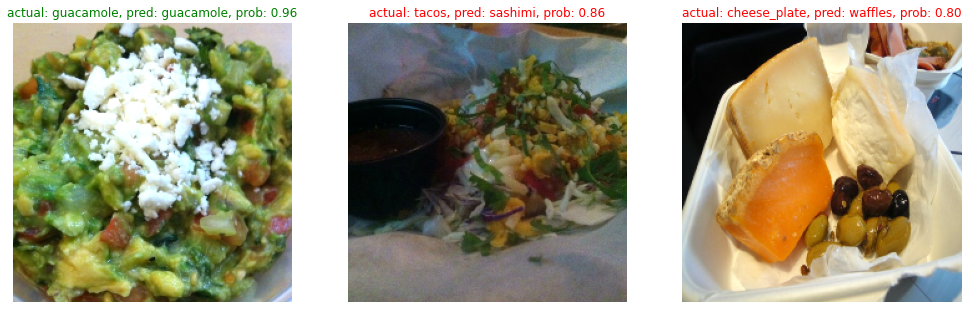

In [121]:
# Make pred on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
    # Choose random image(s) from a random class(es)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename
    
    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model.predict(img_expanded) # get prediction probabilities array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
    # print(pred_prob)
    # print(pred_class)
    
    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    # print(img)
    plt.imshow(img/225.)
    if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

### Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [124]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("data/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]    

[b'data/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [141]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  ...      y_pred_classname
0      b'data/101_food_classes_10_percent/test/apple_...  ...                 gyoza
1      b'data/101_food_classes_10_percent/test/apple_...  ...             apple_pie
2      b'data/101_food_classes_10_percent/test/apple_...  ...             apple_pie
3      b'data/101_food_classes_10_percent/test/apple_...  ...  pulled_pork_sandwich
4      b'data/101_food_classes_10_percent/test/apple_...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'data/101_food_classes_10_percent/test/waffle...  ...               waffles
25246  b'data/101_food_classes_10_percent/test/waffle...  ...          cheese_plate
25247  b'data/101_food_classes_10_percent/test/waffle...  ...               waffles
25248  b'data/101_food_classes_10_percent/test/waffle...  ...  strawberry_shortcake
25249  b'data/101_food_classes_10_percent/test/waffle...  ...               waffles

[25250 rows x 6 columns]

In [142]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'data/101_food_classes_10_percent/test/apple_...  ...         False
1  b'data/101_food_classes_10_percent/test/apple_...  ...          True
2  b'data/101_food_classes_10_percent/test/apple_...  ...          True
3  b'data/101_food_classes_10_percent/test/apple_...  ...         False
4  b'data/101_food_classes_10_percent/test/apple_...  ...         False

[5 rows x 7 columns]

In [143]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

img_path  ...  pred_correct
21810  b'data/101_food_classes_10_percent/test/scallo...  ...         False
231    b'data/101_food_classes_10_percent/test/apple_...  ...         False
15359  b'data/101_food_classes_10_percent/test/lobste...  ...         False
23539  b'data/101_food_classes_10_percent/test/strawb...  ...         False
21400  b'data/101_food_classes_10_percent/test/samosa...  ...         False
...                                                  ...  ...           ...
8763   b'data/101_food_classes_10_percent/test/escarg...  ...         False
2663   b'data/101_food_classes_10_percent/test/brusch...  ...         False
7924   b'data/101_food_classes_10_percent/test/donuts...  ...         False
18586  b'data/101_food_classes_10_percent/test/peking...  ...         False
3519   b'data/101_food_classes_10_percent/test/carrot...  ...         False

[100 rows x 7 columns]

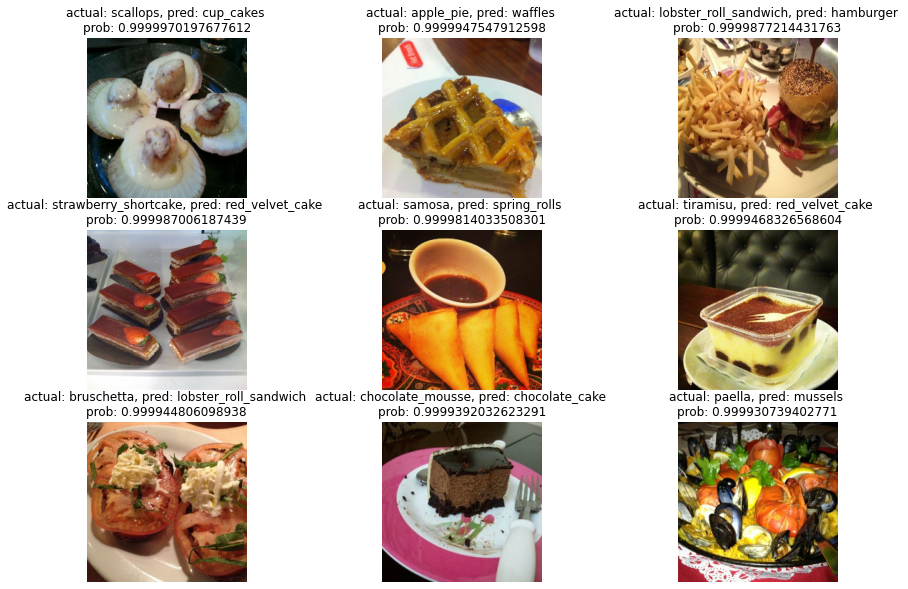

In [151]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3,3,i+1)
    img = load_and_prep_image(row[1], scale=False)
    _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters in each row
    plt.imshow(img/255.)
    plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
    plt.axis(False)

### Test out the big dog model on our own custom images

In [129]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2022-07-18 17:23:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.36.176, 142.251.37.16, 172.217.16.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.36.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  6.25MB/s    in 2.0s    

2022-07-18 17:23:16 (6.25 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [132]:
# Get the custom food images filepaths
custom_food_images = ["data/custom_food_images/" + img_path for img_path in os.listdir("data/custom_food_images")]
custom_food_images

['data/custom_food_images/hamburger.jpeg',
 'data/custom_food_images/steak.jpeg',
 'data/custom_food_images/chicken_wings.jpeg',
 'data/custom_food_images/sushi.jpeg',
 'data/custom_food_images/pizza-dad.jpeg',
 'data/custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


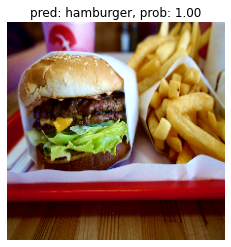

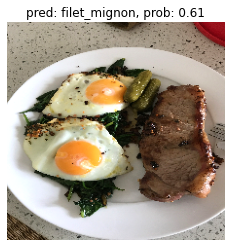

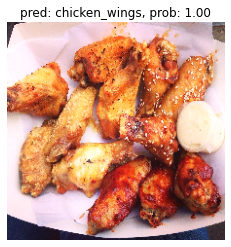

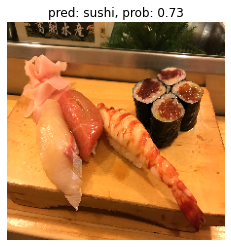

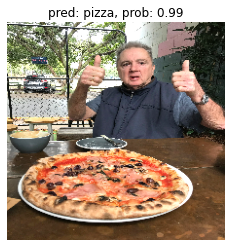

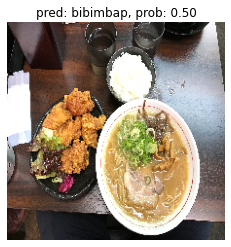

In [133]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)